<a href="https://colab.research.google.com/github/1Stohk1/NLP/blob/main/Attention%20Translator%20-%20ITA%20to%20ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Neural machine translation with attention

This notebook trains a sequence to sequence (seq2seq) model for Italian to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* How the GRUs network works
* What is the Loung's attention

While this methodology is outdated this is still a good starting point to acknowledge on the effectiveness of the Enc-Dec with Attention, despite the actual SoA with the Transformers.

After training the model in this notebook, you will be able to input a Spanish sentence, such as "Sei ancora a casa?", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

## Setup

In [ ]:
!pip install "tensorflow-text==2.8.*"
!pip install telepot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.7 MB/s 
  Created wheel for telepot: filename=telepot-12.7-py3-none-any.whl size=57961 sha256=a818cf0fafdccd1dd8041843c473e50fb45161949bbc4b958c50d6a74fba73a4
  Stored in directory: /root/.cache/pip/wheels/59/4d/ea/8781198a69408b6c37d47d902d7bbe5541969eddf5290e6b2e
Successfully built telepot


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import telepot

In [ ]:
use_builtins = True

## The data

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	Posso prendere in prestito questo libro?
```

They have a variety of languages available, but we'll use the English-Italian dataset.

### Download and prepare the dataset

For convenience, we've hosted a copy of this dataset on Google Drive. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'ita.zip', origin='https://drive.google.com/u/0/uc?id=1KoF4vyAHw6hjXdkJ9j7ybAWeKYS1osW7&export=download',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'ita.txt'

4489216/4479576 [==============================] - 0s 0us/step


In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [ ]:
from sklearn.model_selection import train_test_split

targ, inp = load_data(path_to_file)

targ_train, targ_test, inp_train, inp_test = train_test_split(targ, inp, test_size=0.20, random_state=42)

In [ ]:
print(targ[-1])

Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp_train, targ_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b"L'allenatore \xc3\xa8 frustrato?" b'Siete pronti a volare?'
 b'Grazie per non avermelo detto.' b'Non pensi che ce ne dovremmo andare?'
 b'Tom Jackson \xc3\xa8 uno dei miei cabarettisti preferiti.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Is the coach frustrated?' b'Are you ready to fly?'
 b'Thanks for not telling me.' b"Don't you think we should leave?"
 b'Tom Jackson is one of my favorite comedians.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [ ]:
example_text = tf.constant("Com'è il tempo oggi?")

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b"Com'\xc3\xa8 il tempo oggi?"
b"Com'e\xcc\x80 il tempo oggi?"


Unicode normalization will be the first step in the text standardization function:

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Com'è il tempo oggi?
[START] come il tempo oggi ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other preprocessing layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

In [ ]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'tom', '?', 'non', 'e', 'di']

That's the Italian `TextVectorization` layer, now build and `.adapt()` the English one:

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'tom', 'you', 'i', 'to', '?']

Now these layers can convert a batch of strings into a batch of token IDs:

In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    1,    8, 3047,    6,    3,    0,    0,    0,    0],
       [   2,   63, 1034,   10, 1546,    6,    3,    0,    0,    0],
       [   2,  422,   18,    7,    1,   62,    4,    3,    0,    0]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] [UNK] e frustrato ? [END]       '

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [ ]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)

    # 3. The GRU processes the embedding sequence.
    output, state = self.gru(vectors, initial_state=state)

    # 4. Returns the new sequence and its state.
    return output, state

The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_1.jpg?raw=1" alt="attention equation 1" width="800">

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_2.jpg?raw=1" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_4.jpg?raw=1" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_3.jpg?raw=1" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](text_generation.ipynb) tutiorial.


## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

  def train_step(self, inputs):
    return self._tf_train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [ ]:
def _preprocess(self, input_text, target_text):

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)

  # Convert IDs to masks.
  input_mask = input_tokens != 0

  target_mask = target_tokens != 0

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):  
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=5,
                     callbacks=[batch_loss])

Epoch 1/5
4428/4428 [==============================] - 1037s 232ms/step - batch_loss: 1.1292
Epoch 2/5
4428/4428 [==============================] - 1003s 226ms/step - batch_loss: 0.5070
Epoch 3/5
4428/4428 [==============================] - 994s 224ms/step - batch_loss: 0.3747
Epoch 4/5
4428/4428 [==============================] - 993s 224ms/step - batch_loss: 0.2961
Epoch 5/5
4428/4428 [==============================] - 985s 222ms/step - batch_loss: 0.2504


Text(0, 0.5, 'CE/token')

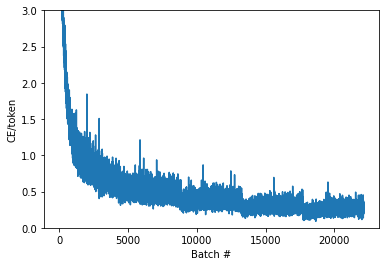

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [ ]:
def tokens_to_text(self, result_tokens):
  result_text_tokens = self.output_token_string_from_index(result_tokens)

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')

  result_text = tf.strings.strip(result_text)
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'seventeen brainwashed', b'his objection', b'material bananas',
       b'lack passport', b'last closed'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [ ]:
def sample(self, logits, temperature):

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  

  return new_tokens

In [ ]:
Translator.sample = sample

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

Run it on a simple input:

In [ ]:
%%time
input_text = tf.constant([
    'Fa molto freddo qui.', # "It's really cold here."
    'Questa è la mia vita.', # "This is my life.""
])

CPU times: user 89 µs, sys: 10 µs, total: 99 µs
Wall time: 105 µs


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.


In [ ]:
#@title  { display-mode: "form" }
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)
  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  
  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])

  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = attention.stack()

    attention_stack = tf.squeeze(attention_stack, 2)

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_symbolic

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.8 s, sys: 280 ms, total: 2.08 s
Wall time: 3.47 s


# Bleu Score

Now we want to find out how our model is performing using the Bleu score, with progressive N-Grams from 1 till 4. The score will be compared with other kind of model to find out which is the best one in the translation of sentences.

In [ ]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu

score = 0
for target, input in zip(targ_test, inp_test):
  input_text = tf.constant([
                            input
  ])
  result = translator.tf_translate(input_text)
  candidate = result['text'][0].numpy().decode()

  candidate = candidate.replace(',', ' ,').replace('.', ' .').split(" ")
  reference = target.lower().replace(',', ' ,').replace('.', ' .').replace("'", "").split(' ')

  score += sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
score = score/len(targ_test)
print(score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

6.854948959770019e-159


In [ ]:
# Notifying the bot on Telegram
token = '5453584270:AAHIZnD7IoHRWzSmzQR_yGU2T-676IVmSoo'
receiver = 806724607

bot = telepot.Bot(token)

bot.sendMessage(receiver, "The training of the Translator has been completed and it reached the score:" + str(score))

ProtocolError: ignored

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
tf.saved_model.save(translator, '/content/drive/MyDrive/Colab/HLT/TraduttoreITA',
                    signatures={'serving_default': translator.tf_translate})